The graph partitioning algorithms based on the two mathematical programming models (Aref and Neal 2021) for optimally partitioning signed networks based on generalized balance and computing the exact values of k-clusterability index and clusterability index.

These algorithms are written in Python 3.8 based on the two graph optimization models discussed in Aref and Neal (2021).

Binary linear programming models for partitioning signed graphs based on generalized balance theory and computing the exact values of k-clusterability index and clusterability index - Jupyter code written by Samin Aref in 2019

Creative common license: Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)

Using this code for non-commercial purposes is permitted to all given that the following publication is cited:

Aref, S., and Neal, Z.P., "Identifying hidden coalitions in the US House of Representatives by optimally partitioning signed networks based on generalized balance" (2021) Scientific Reports.

Related dataset and R code repository (for further analysis of the optimal partitions):

Neal, Z.P. and Aref, S., "Frustrated Legislators: Replication data and code" Figshare research data repository (2021). https://doi.org/10.17605/OSF.IO/3QTFB

Suggested articles and other relevant datasets:

    Aref, S, Mason, AJ, Wilson, MC. A modeling and computational study of the frustration index in signed networks. Networks. 2020; 75: 95– 110. url: https://doi.org/10.1002/net.21907


    Aref, S., Mason, A. J., and Wilson, M. C., Computing the line index of balance using integer programming optimisation. In Optimization Problems in Graph Theory, B. Goldengorin, Ed. Springer, 2018, pp. 65-84. url: https://doi.org/10.1007/978-3-319-94830-0_3


    Aref, S., and Neal, Z., Detecting Coalitions by Optimally Partitioning Signed Networks of Political Collaboration. Scientific Reports (2020). url: http://arxiv.org/pdf/1906.01696.


    Aref, S., and Wilson, M. C. Balance and frustration in signed networks. Journal of Complex Networks 7, 2 (2019), 163–189. doi: 10.1093/comnet/cny015.
    
    
    Aref, S., and Wilson, M. C. Measuring partial balance in signed networks. Journal of Complex Networks 6, 4 (2018), 566-595. doi: 10.1093/comnet/cnx044. 
    
    
    Aref, S. Signed networks from sociology and political science, systems biology, international relations, finance, and computational chemistry. Figshare research data repository (2017). doi: 10.6084/m9.figshare.5700832.v2.



# Downloading the network data
The 19 signed networks of the US House can be downloaded from the following repository as a zip file (network_data.zip) which can then be extracted and read from your local storage in the next chunk of code.
Neal, Z.P. and Aref, S., "Frustrated Legislators: Replication data and code" Figshare research data repository (2021). https://doi.org/10.17605/OSF.IO/3QTFB


In [8]:
# Loading signed graphs from CSV files
# Each file is one graph which becomes one instance for the
# optimization model

# Change 'path' based on the directory where you have copied 
# the network data (csv files of US House networks from Aref and Neal 2021)

import networkx as nx
import csv
import numpy as np

Graph=[]
signedMatrix=[]
unsignedMatrix=[]
sorted_weighted_edges=[]
order=[]
size=[]
NumberOfNegative=[]

path='network_data\\'

chamber='H' #for House of Representatives

start_year=int(input("Start session (inclusive)? (97,98,...,115)"))
end_year=int(input("End session (exclusive)? (98,99,...,116)"))

run=end_year-start_year

for i in range(run):

    matrix=np.loadtxt(open(path+chamber.upper()+str(i+start_year)+".csv", "rb"), delimiter=",", skiprows=1)
    order.append(len(np.matrix(matrix)))
    
    signedMatrix.append(np.matrix(matrix))
    unsignedMatrix.append(abs(np.matrix(matrix)))

    Graph.append(nx.from_numpy_matrix(signedMatrix[i]))
    sorted_weighted_edges.append(nx.get_edge_attributes(Graph[i], 'weight'))

    size.append(int(np.count_nonzero(signedMatrix[i]))/2)
    NumberOfNegative.append(((-1 == signedMatrix[i])).sum()/2)
    
    print("Signed network for session",i+start_year,"is generated")       


Start session (inclusive)? (97,98,...,115)97
End session (exclusive)? (98,99,...,116)98
Signed network for session 97 is generated


In [2]:
# Sanity check to make sure the signed networks are loaded correctly
# The numbers printed must match the numbers in Table S1 of the 
# Scientific Reports article (Aref and Neal 2021)

print("n")
for index in range(run):
    print(order[index])   

print("m")    
for index in range(run):
    print(size[index])
    
print("m-")
for index in range(run):
    print(NumberOfNegative[index])


n
447
m
4954.0
m-
4494.0


In [3]:
# Partitioning based on generalized balance for a given predefined
# number of clusters (the parameter maximum_colour)

# Forcing the exact number of predefined clusters to be used

# Solves multiple instances based on the number of input graphs


import numpy as np
import multiprocessing
import copy
import time
from gurobipy import *
maximum_colour=int(input("What is the predefined number of clusters?"))
objectivevalue=[]
solveTime=[]
effectiveBranchingFactors=[]
optimal_partition=[]

for index in range(run):

    degree=(signedMatrix[index]).sum(1)
    unsignedDegree=(unsignedMatrix[index]).sum(1)

    x=[]
    f={}

    # Model
    model = Model("Multi-colour frustration")
    
    # How many threads to be used for exploring the feasible space in parallel?
    # Here, the minimum of 32 and the availbale CPUs is used
    model.setParam(GRB.Param.Threads, min(32,multiprocessing.cpu_count()))
    
    # Do you want details of branching to be reported? (0=No, 1=Yes)
    model.setParam(GRB.param.OutputFlag, 1) 
    
    # Do you want a non-zero Mixed integer programming tolerance (MIP Gap)?
    # Note that a non-zero MIP gap may prevent the model from computing the exact value of frustration index
    # model.setParam('MIPGap', 0.175)  
    
    # There are different methods for solving optimization models:
    # (-1=automatic, 0=primal simplex, 1=dual simplex, 2=barrier, 3=concurrent, 4=deterministic concurrent)
    # For problems with a large number of contstraints, barrier method is more suitable
    #model.setParam(GRB.param.Method, -1)

    # Creating the decision variables
    for i in range(0,order[index]):
        x.append([])
        for c in range(maximum_colour):
            x[i].append(model.addVar(lb=0.0, ub=1, vtype=GRB.BINARY, name='x'+str(i)+','+str(c))) # arguments by name

    for (i,j) in (sorted_weighted_edges[index]):
            f[(i,j)]=model.addVar(lb=0.0, ub=1, vtype=GRB.BINARY, name='f'+str(i)+','+str(j))

    # Updating the model to integrate new variables
    model.update()
    
    OFV=0        
    for (i,j) in (sorted_weighted_edges[index]):
        OFV = OFV + f[(i,j)]              
    model.setObjective(OFV, GRB.MINIMIZE)

    # Adding constraints to the model
    for c in range(maximum_colour):
        for (i,j) in (sorted_weighted_edges[index]):
            if (sorted_weighted_edges[index])[(i,j)]==1:
                model.addConstr( f[(i,j)] >= x[i][c] - x[j][c]  , 'posEdge'+','+str(i)+','+str(j))       
            if (sorted_weighted_edges[index])[(i,j)]==-1:
                model.addConstr( f[(i,j)] >= x[i][c] + x[j][c] -1  , 'negEdge'+','+str(i)+','+str(j))

    # Constraint to ensure every node takes a color.
    for i in range (0,order[index]):
         model.addConstr(gurobipy.quicksum((x[i][c] for c in range(maximum_colour))) == 1)
            
    # Additional constraint to force all colors to be used
    for c in range(maximum_colour):
         model.addConstr(gurobipy.quicksum((x[i][c] for i in range(order[index]))) >= 1)
    
    #model.addConstr(OFV >= 200, 'LP lower bound')    
    model.update()
 

    # Solving the mathematical optimization model
    start_time = time.time()
    model.optimize()
    solveTime.append(time.time() - start_time) 
    print('Model', index+start_year,"solve time:",(time.time() - start_time))
    
    obj = model.getObjective()
    objectivevalue.append((obj.getValue()))
    print('Model', index+start_year,' optimal solution equals',objectivevalue[index]) 
    
    
    # Constructing the optimal partition based on the optimal solution
    optimal_partition.append([])
    for v in model.getVars():
        if v.varName.startswith('x'):
            if v.x>0.9:
                (optimal_partition[index]).append(int(v.varName[-1]))
                #print (v.varName, v.x)   
    #for color in optimal_partition[index]:
    #    print(color)
    
print("Clusterability indices ( k=",maximum_colour,"):",objectivevalue)
#print("frustrarion index Average",np.mean(objectivevalue))
#print("Frustration index SD     ",np.std(objectivevalue))
print("Solve times:",np.around(solveTime, decimals=2))
#print("Average solve time",np.mean(solveTime))
#print("Solve time Standard Deviation",np.std(solveTime))
print()
#for index in range(run):
#    print(objectivevalue[index])

what is the predefined number of clusters?3
Academic license - for non-commercial use only - expires 2022-08-29
Using license file C:\Users\Aref\gurobi.lic
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 15312 rows, 6295 columns and 47268 nonzeros
Model fingerprint: 0x95adac15
Variable types: 0 continuous, 6295 integer (6295 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1801.0000000
Presolve time: 0.08s
Presolved: 15312 rows, 6295 columns, 47268 nonzeros
Variable types: 0 continuous, 6295 integer (6295 binary)

Root relaxation: objective 0.000000e+00, 1548 iterations, 0.23 seco

In [4]:
# Saving the optimal partitions as one row for each network in a csv file

import pandas as pd
df_save = pd.DataFrame(optimal_partition)
df_save.to_csv('optimal_'+str(maximum_colour)+'_partitions.csv', index=False, header=False)

In [5]:
# This code is for producing synthetic data (generating random "signed graphs")
# "Signed graphs" are graphs in which edges are postive or negative (signed)
# This code asks you for type of random graph, several parameters for generating them such as size and order
# and then it asks for "number of negative edges" so that it randomly makes some edges negative and produce 
# a signed graph out of an unsigned graph

import networkx as nx
import numpy as np
import random

listOfGraphs=[]
NumberOfNegative=[]
run=int(input("How many random graphs do you want to create?(1/2/...)"))

print("\n 1.  Erdős-Rényi binomial graph G_{n,p} "
      "\n 2.  Random graph of n nodes and m total edges G_{n,m} "
      "\n 3.  Newman-Watts-Strogatz small world graph (adding new edges to the ring) G_{n,k,p} "
      "\n 4.  Watts-Strogatz small world graph (rewiring the ring) G_{n,k,p} "
      "\n 5.  Random regular graph of n nodes each with degree d G_{d,n} "
      "\n 6.  Barabási-Albert preferential attachment model graph G_{n,m} "
      "\n 7.  Growing graph with powerlaw degree distribution and approximate average clustering G_{n,m,p}"
      "\n 8.  Two-dimensional grid n*n ")

graph_type=int(input("What type of random graph(s) do you want to create from the list above? (1/2/...)"))

for i in range(run):

    if graph_type == 1:
        n=int(input("What is the number of nodes?"))
        p=float(input("What is the probability of having an edge for each two nodes? (0.1, 0.5, ...)"))
        NumberOfNegative.append(int(input("What is the number of negative edges for this instance? (0/1/2/.../m)")))
        G=nx.fast_gnp_random_graph(n,p)
        listOfGraphs.append(G) 
    elif graph_type == 2:
        n=int(input("What is the number of nodes?"))
        m=int(input("What is the total number of edges?"))  
        NumberOfNegative.append(int(input("What is the number of negative edges for this instance? (0/1/2/.../m)")))
        G=nx.gnm_random_graph(n,m)
        listOfGraphs.append(G)
    elif graph_type == 3:
        n=int(input("What is the number of nodes?"))
        k=int(input("What is the number of nearest neighbors in ring topology?"))
        p=float(input("What is the probability of adding a new edge?"))
        NumberOfNegative.append(int(input("What is the number of negative edges for this instance? (0/1/2/.../m)")))
        G=nx.newman_watts_strogatz_graph(n,k,p)
        listOfGraphs.append(G)
    elif graph_type == 4:
        n=int(input("What is the number of nodes?"))
        k=int(input("What is the number of nearest neighbors in ring topology?"))
        p=float(input("What is the probability of rewiring each edge?"))
        NumberOfNegative.append(int(input("What is the number of negative edges for this instance? (0/1/2/.../m)")))
        G=nx.watts_strogatz_graph(n,k,p)
        listOfGraphs.append(G)
    elif graph_type == 5:
        n=int(input("What is the number of nodes?(n>d)"))
        d=int(input("What is the degree?(The value of n*d must be even)"))
        NumberOfNegative.append(int(input("What is the number of negative edges for this instance? (0/1/2/.../m)")))
        G=nx.random_regular_graph(d,n)
        listOfGraphs.append(G)
    elif graph_type == 6:
        n=int(input("What is the number of nodes?"))
        m=int(input("What is the number of edges to attach from a new node to existing nodes?"))
        NumberOfNegative.append(int(input("What is the number of negative edges for this instance? (0/1/2/.../m)")))
        G=nx.barabasi_albert_graph(n,m)   
        listOfGraphs.append(G)
    elif graph_type == 7:
        n=int(input("What is the number of nodes?"))
        m=int(input("What is the number of random edges to add for each new node?"))
        p=float(input("What is the probability of adding a triangle after adding a random edge?"))
        NumberOfNegative.append(int(input("What is the number of negative edges for this instance? (0/1/2/.../m)")))
        G=nx.powerlaw_cluster_graph(n,m,p)    
        listOfGraphs.append(G)
    elif graph_type == 8:
        n=int(input("What is the size of the grid?(sqrt(n))"))
        NumberOfNegative.append(int(input("What is the number of negative edges for this instance? (0/1/2/.../m)")))
        G=nx.grid_2d_graph(n,n)
        mapping=dict(zip(G.nodes(),range(len(G.nodes()))))
        G=nx.relabel_nodes(G,mapping)
        listOfGraphs.append(G)
    else:
        print("Try again and choose a graph type from the selection above!")

                    
Graph=[]
signedMatrix=[]
unsignedMatrix=[]
ShuffledEdges=[]
sorted_weighted_edges=[]
size=[]
order=[]


for i in range(run):
        ShuffledEdges = list(listOfGraphs[i].edges())
        random.shuffle(ShuffledEdges)
        Graph.append(nx.Graph())
        for u in listOfGraphs[i].nodes():
            Graph[i].add_node(u)
        for ind in range(0,NumberOfNegative[i]):
            (u,v) = ShuffledEdges[ind]
            Graph[i].add_edge(u,v,weight=-1)
        for ind in range(NumberOfNegative[i],len(listOfGraphs[i].edges())):
            (u,v) = ShuffledEdges[ind]
            Graph[i].add_edge(u,v,weight=1)
        signedMatrix.append(nx.to_numpy_matrix(Graph[i]))
        unsignedMatrix.append(abs(signedMatrix[i]))
        ShuffledEdges=[]
        size.append(int(np.count_nonzero(signedMatrix[i])/2))
        order.append(int(len(signedMatrix[i])))

        weighted_edges=nx.get_edge_attributes(Graph[i], 'weight') 
        sorted_weighted_edges.append({})
        for (u,v) in weighted_edges:
            if u<v:
                (sorted_weighted_edges[i])[(u,v)] = weighted_edges[(u,v)]
            if u>v:
                (sorted_weighted_edges[i])[(v,u)] = weighted_edges[(u,v)]          
          

How many random graphs do you want to create?(1/2/...)1

 1.  Erdős-Rényi binomial graph G_{n,p} 
 2.  Random graph of n nodes and m total edges G_{n,m} 
 3.  Newman-Watts-Strogatz small world graph (adding new edges to the ring) G_{n,k,p} 
 4.  Watts-Strogatz small world graph (rewiring the ring) G_{n,k,p} 
 5.  Random regular graph of n nodes each with degree d G_{d,n} 
 6.  Barabási-Albert preferential attachment model graph G_{n,m} 
 7.  Growing graph with powerlaw degree distribution and approximate average clustering G_{n,m,p}
 8.  Two-dimensional grid n*n 
What type of random graph(s) do you want to create from the list above? (1/2/...)6
What is the number of nodes?20
What is the number of edges to attach from a new node to existing nodes?4
What is the number of negative edges for this instance? (0/1/2/.../m)10


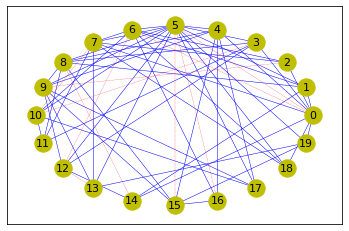

In [6]:
# Visualizing the random signed network created in the previous step
# (visualizing the i-th network, if created multiple signed network)

import matplotlib.pyplot as plt
%matplotlib inline

i=0

w=nx.get_edge_attributes(Graph[i], 'weight')
positive_edges=[]
for (u,v) in Graph[i].edges():
    if w[(u,v)]==1:
        positive_edges.append((u,v))
negative_edges=[]
for (u,v) in Graph[i].edges():
    if w[(u,v)]== -1:
        negative_edges.append((u,v))

pos = nx.circular_layout(Graph[i], dim=2, scale=1)
nx.draw_networkx_nodes(Graph[i], pos, node_color='y')
nx.draw_networkx_edges(Graph[i], pos, edgelist=positive_edges, edge_color='b', width=0.5, style='solid')
nx.draw_networkx_edges(Graph[i], pos, edgelist=negative_edges, edge_color='r', width=0.25, style='dashed')
#nx.draw_networkx_edges(Graph[i], pos, edgelist=frustrated_edges, style='dashdot')
nx.draw_networkx_labels(Graph[i],pos,font_size=11,font_family='sans-serif')
plt.show()

In [7]:
# Correlation clustering (generalized balance without specifying k,
# the number of clusters)
# This model is based on the formulation by Demaine et al.,
# Correlation clustering in general weighted graphs. Theor. Comput.
# Sci. 361, 172–187 (2006). 
# We have reformulated it such that the constraints are for
# the set of connected triples. Therefore, it is more efficient 
# for possibly non-complete graphs and particularly for sparse graphs

# Solves multiple instances based on the number of input graphs

# The model uses continuous variables in the unit interval

import time
import copy
import numpy as np
import multiprocessing
from gurobipy import *
objectivevalue=[]
solveTime=[]
effectiveBranchingFactors=[]
number_of_subsets=[]
single_member=[]
collaborative_groups=[]

def find_in_list_of_list(mylist, char):
    for sub_list in mylist:
        if char in sub_list:
            return (mylist.index(sub_list))
    raise ValueError("'{char}' is not in list".format(char = char))

for index in range(run):
    
    #This chunck of code lists all graph triads (open and closed)
    generator_of_triads=(nx.all_triads((Graph[index]).to_directed()))
    list_of_triads=[]
    for triad in generator_of_triads:
        list_of_triads.append(list(triad.nodes()))


    degree=(signedMatrix[index]).sum(1)
    unsignedDegree=(unsignedMatrix[index]).sum(1)

    x={}
    clustered=[]

    # Model
    model = Model("Correlation clustering")
    # There are different methods for solving optimization models:
    # (-1=automatic, 0=primal simplex, 1=dual simplex, 2=barrier, 3=concurrent, 4=deterministic concurrent)
    # For problems with a large number of contstraints, barrier method is more suitable
    model.setParam(GRB.param.Method, 2)
    
    # Solving the problems without crossover takes a substantially shorter time
    # in cases where there are a large number of constraints. (0=without, 1=with)
    model.setParam(GRB.Param.Crossover, 0)
    
    # Do you want details of branching to be reported? (0=No, 1=Yes)
    model.setParam(GRB.param.OutputFlag, 1) 
    
    # How many threads to be used for exploring the feasible space in parallel?
    # Here, the minimum of 64 and the availbale CPUs is used
    model.setParam(GRB.Param.Threads, min(32,multiprocessing.cpu_count()))

    # Create decision variables
    # Note that there are variables for every pair of nodes i,j such that i<j
    # The variable takes 1 iff i and j belong to the same group and it takes 0 otherwise
    for i in (Graph[index]).nodes():
        for j in filter(lambda x: x>i, (Graph[index]).nodes()):
            x[(i,j)]=model.addVar(lb=0.0, ub=1, vtype=GRB.BINARY, name=str(i)+','+str(j))
            if (i,j) not in sorted_weighted_edges[index]:
                (sorted_weighted_edges[index])[(i,j)]=0


    # Update model to integrate new variables
    model.update()
    
    # The term in the objective function for a pair of nodes without an edge is 0
    # The term in the objective function for a positive edge is 1-xij
    # The term in the objective function for a negative edge is xij
    OFV=0

    for (i,j) in (sorted_weighted_edges[index]):
            OFV = OFV + ((sorted_weighted_edges[index])[(i,j)])*((((sorted_weighted_edges[index])[(i,j)])+1)/2)\
            -((sorted_weighted_edges[index])[(i,j)])*x[(i,j)] 


    model.setObjective(OFV, GRB.MINIMIZE)

    # Add constraints to the model
    for triangle in list_of_triads:
        i=min(triangle)
        k=max(triangle)
        triangle.remove(i)
        triangle.remove(k)
        j=triangle[0]
        model.addConstr(x[(i,j)] + x[(i,k)] <= 1+x[(j,k)] , 'triangle1'+','+str(i)+','+str(j)+','+str(k))
        model.addConstr(x[(i,j)] + x[(j,k)] <= 1+x[(i,k)] , 'triangle2'+','+str(i)+','+str(j)+','+str(k))       
        model.addConstr(x[(j,k)] + x[(i,k)] <= 1+x[(i,j)] , 'triangle3'+','+str(i)+','+str(j)+','+str(k))
    model.update()
    
    #model.addConstr(OFV <= int(UpperBounds[index]), 'LP Upper bound')
    model.update()
   
    # Solve
    start_time = time.time()
    model.optimize()
    solveTime.append(time.time() - start_time) 
    
    obj = model.getObjective()
    objectivevalue.append((obj.getValue()))
    print('Instance',index,': clusterability index equals',objectivevalue[index]) 
    
    
    for v in model.getVars():
    #if v.varName.startswith('x'):
        if v.x!=0:
            clustered.append((v.varName).split(","))
            #print (v.varName, v.x)
            
    #print(clustered)
    
    # Computing the number of subsets in the k-color solution

    reduction=0
    i=0
    visited_endpoints=[]
    group=[]
    for pair in clustered:
        if pair[0] not in visited_endpoints and pair[1] not in visited_endpoints:
            reduction=reduction+1
            visited_endpoints.append(pair[0])
            visited_endpoints.append(pair[1])
            group.append([])
            (group[i]).append(pair[0])
            (group[i]).append(pair[1])
            i=i+1
        if pair[0] not in visited_endpoints and pair[1] in visited_endpoints:
            reduction=reduction+1
            index_one=find_in_list_of_list(group, pair[1])
            (group[index_one]).append(pair[0])
            visited_endpoints.append(pair[0])
        if pair[1] not in visited_endpoints and pair[0] in visited_endpoints:
            reduction=reduction+1
            index_zero=find_in_list_of_list(group, pair[0])
            (group[index_zero]).append(pair[1])
            visited_endpoints.append(pair[1])
        if pair[0] in visited_endpoints and pair[1] in visited_endpoints:
            index_zero=find_in_list_of_list(group, pair[0])
            index_one=find_in_list_of_list(group, pair[1])
            if index_zero!=index_one:
                reduction=reduction+1
                group[index_zero]=group[index_zero]+group[index_one]
                del group[index_one]
                i=i-1

            
    collaborative_groups.append(len(group))        
    number_of_subsets.append(order[index]-reduction)
    single_member.append(order[index]-len(visited_endpoints))

    #print("reduction:",reduction)
    #print("visited endpoints:",visited_endpoints)
    print("Groups:",group)
    print("Non-collaborators:",order[index]-len(visited_endpoints))
    print("Collaborative groups count:",len(group))
    #print("Number of subsets:",order[index]-reduction)
    print()

    
print("-"*32,"***  EXPERIMENT STATS  ***","-"*32)
print("-"*92)         
    
#print("Clusterbility indices:",objectivevalue)
#print("frustrarion index Average",np.mean(objectivevalue))
#print("Frustration index SD     ",np.std(objectivevalue))
print("Solve times:",np.around(solveTime, decimals=2))
#print("Average solve time",np.mean(solveTime))
#print("Solve time Standard Deviation",np.std(solveTime))


print("Q_k")
for index in range(run):
    print(objectivevalue[index])
print("Cohesive groups")
for index in range(run):
    print(collaborative_groups[index])
print("Non-collaborators count")
for index in range(run):
    print(single_member[index])


Changed value of parameter Method to 2
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Crossover to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 3420 rows, 190 columns and 10260 nonzeros
Model fingerprint: 0x6c396059
Variable types: 0 continuous, 190 integer (190 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 45.0000000
Found heuristic solution: objective 10.0000000
Presolve time: 0.02s
Presolved: 3420 rows, 190 columns, 10260 nonzeros
Variable types: 0 continuous, 190 integer (190 binary)
Root barrier log...

O